In [1]:
%load_ext autoreload
%autoreload 2

In [342]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import time
import SentimentModel
import random
import re
import pickle
import seaborn as sns

In [3]:
# #ONLY HAVE TO RUN BELOW ONCE, WE CAN LOAD LATER
# stock_prices = dict()

# for t in stock_tweets.ticker.unique():
#     stock_prices[t] = yf.download(t.replace('$', ""))

# items = list(stock_prices.items())
# for k,v in items:
#     if(v.shape[0] == 0):
#         del stock_prices[k]

# with open('stock_prices.pkl', 'wb') as f:
#     pickle.dump(stock_prices, f, pickle.HIGHEST_PROTOCOL)

In [4]:
stock_prices = None
with open('stock_prices.pkl', 'rb') as f:
    stock_prices = pickle.load(f)

In [5]:
data = pd.read_csv('user_timeline_tweets.csv')

In [6]:
data = data.drop(['_id', 'id', 'date'], axis=1)

In [7]:
data

,text,time,user
0,The list of reasons why the financial market’s...,2022-05-11T08:46:29.000Z,MarketWatch
1,Stablecoin TerraUSD plunges to as low as 30 ce...,2022-05-11T08:36:55.000Z,MarketWatch
2,Stablecoin Terra falls as low as 30 cents on t...,2022-05-11T08:20:54.000Z,MarketWatch
3,It is a good time for the Federal Reserve to “...,2022-05-11T08:20:40.000Z,MarketWatch
4,"Just weeks before Memorial Day weekend, the la...",2022-05-11T07:53:17.000Z,MarketWatch
...,...,...,...
52128,RT @BBCBreaking: Former Trump adviser Steve Ba...,2020-08-20T13:50:01.000Z,Seana Smith
52129,"RT @YahooFinance: Highlight: ""Much to the dism...",2020-08-20T01:43:32.000Z,Seana Smith
52130,RT @DeItaOne: KUDLOW SAYS DOES NOT SEE A FEDER...,2020-08-07T14:36:02.000Z,Seana Smith
52131,BofA: Downgrading $AAPL to Neutral as we view ...,2020-08-05T14:00:46.000Z,Seana Smith


In [8]:
columns = ['text', 'ticker', 'time', 'user']
stock_tweets = []

regex = r'(\$[A-Z]+)'
for i,row in data.iterrows():
    tickers = re.findall(regex, row['text'])
    visited = set()
    for t in tickers:
        if t in visited:
            continue
        visited.add(t)
        stock_tweets.append([row['text'], t, row['time'], row['user']])

In [9]:
stock_tweets = pd.DataFrame(stock_tweets, columns=columns)

In [10]:
stock_tweets.time = pd.to_datetime(stock_tweets.time)

In [11]:
stock_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   text    2357 non-null   object             
 1   ticker  2357 non-null   object             
 2   time    2357 non-null   datetime64[ns, UTC]
 3   user    2357 non-null   object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 73.8+ KB


# We will take the standard market open and close times UTC 14:30:00 to 21:00:00

In [12]:
MARKET_OPEN = datetime.time()
MARKET_CLOSE = datetime.time(21,0,0)

In [13]:
def correct_dates(dt_obj):
    if(dt_obj.time() < MARKET_CLOSE):
        return dt_obj.date()
    timedelta = datetime.timedelta(days=1)
    dt_obj += timedelta
    return dt_obj.date()

In [14]:
stock_tweets['date'] = stock_tweets.time.apply(lambda x : correct_dates(x))

In [15]:
stock_prices['$TSLA'].loc['2022-05-10'].name.date()

datetime.date(2022, 5, 10)

# Get sentiment scores for all the tweets

In [16]:
model = SentimentModel.SentimentModel(model_path='models/model', load_model=True)

In [20]:
sentiment_labels = ['negative', 'neutral', 'positive']
sentiments = pd.DataFrame(model.predict_proba(stock_tweets['text']), columns=sentiment_labels)

In [21]:
sentiments.head()

,negative,neutral,positive
0,0.006106,0.838109,0.155786
1,0.030165,0.837477,0.132358
2,0.000636,0.985662,0.013702
3,0.905105,0.056764,0.038132
4,0.054616,0.814632,0.130753


In [22]:
stock_tweets = pd.concat([stock_tweets, sentiments], axis=1)

In [31]:
stock_tweets.sort_values(['date'])

,text,ticker,time,user,date,negative,neutral,positive
1517,"@CarlCICahn Dow down 212, $TSLA up as I noted ...",$TSLA,2013-08-15 17:46:46+00:00,Carl C Icahn,2013-08-15,0.001959,0.997392,0.000649
1515,"$AAPL -0.16%, $SPY -1.46%\nI CAH N",$AAPL,2013-08-15 19:28:33+00:00,Carl C Icahn,2013-08-15,0.088411,0.781266,0.130323
1514,$AAPL GREEN \nI print more $$ than Ben C Bernake,$AAPL,2013-08-15 19:31:28+00:00,Carl C Icahn,2013-08-15,0.001520,0.031381,0.967099
1513,My next bet CHINA MOBILE $CHL Will force them ...,$AAPL,2013-08-15 19:45:06+00:00,Carl C Icahn,2013-08-15,0.119321,0.868312,0.012367
1512,My next bet CHINA MOBILE $CHL Will force them ...,$CHL,2013-08-15 19:45:06+00:00,Carl C Icahn,2013-08-15,0.119321,0.868312,0.012367
...,...,...,...,...,...,...,...,...
2020,"At $4.8 million, $XL is just a bit off pace to...",$XL,2022-05-10 21:15:22+00:00,🇺🇦 MuddyWatersResearch,2022-05-11,0.076711,0.007015,0.916275
1328,$LUNA still crashing https://t.co/1Q0g9PxG4L,$LUNA,2022-05-10 21:52:23+00:00,Joe Weisenthal,2022-05-11,0.870874,0.010608,0.118518
553,Great numbers from Callaway Golf. I like what ...,$ELY,2022-05-10 22:29:58+00:00,Ross Gerber,2022-05-11,0.001238,0.002129,0.996632
1327,Want to short $LUNA? Cost to borrow is just 12...,$LUNA,2022-05-10 22:53:27+00:00,Joe Weisenthal,2022-05-11,0.934412,0.006240,0.059348


In [76]:
def get_date_range(from_date, to_date):
    return stock_prices['$TSLA'][(stock_prices['$TSLA'].index.date >= from_date) & (stock_prices['$TSLA'].index.date <= to_date)].index.date

# Simulation and Agents

In [334]:
class AgentRandom:
    def __init__(self, tweets, random_state=time.time()):
        self.tweets = tweets
        random.seed(random_state)
    
    def get_trades(self, from_date, to_date, portfolio, terminal): # dates must be in datetime.date format
        relevant_tweets = self.tweets[(self.tweets.date > from_date) & (self.tweets.date <= to_date)]
        
        tickers = relevant_tweets.groupby('ticker').mean().index;
        
        trades = []
        for t in tickers:
            trades.append([t, random.randrange(0,3), random.random()])
        return trades

In [335]:
class AgentSentiment:
    def __init__(self, tweets, window_size = 3):
        self.tweets = tweets
        self.window_size = window_size
    
    def get_trades(self, from_date, to_date, portfolio, terminal):
        delta = (to_date - from_date).days
        from_date -= datetime.timedelta(days=max(0, self.window_size - delta))
        relevant_tweets = self.tweets[(self.tweets.date > from_date) & (self.tweets.date <= to_date)]
        
        trades = []
        for ticker, row in relevant_tweets.groupby('ticker').mean().iterrows():
            pred = np.argmax(row)
            pred_proba = np.max(row)
            power = (pred_proba - 0.33)/0.66
            # power = 1
            trades.append([ticker, pred, power])
        return trades

In [333]:
list(stock_tweets.groupby('ticker').mean().iloc[0,:])

[0.1282164603471756, 0.40410739183425903, 0.46767616271972656]

In [409]:
%run RLAgent.ipynb
class AgentQ:
    def __init__(self, tweets, stock_prices, window_size = 3, model_path = None):
        self.tweets = tweets
        self.stock_prices = stock_prices
        self.window_size = window_size
        self.previous_state_actions = dict()
        self.agent = RLAgent(modelPath = model_path)
        self.epsilon = 1.0
        self.cum_reward = 0
        
    def reset_episode(self):
        self.previous_state_actions = dict()
        self.cum_reward = 0
        
    def get_trades(self, from_date, to_date, portfolio, terminal):
        delta = (to_date - from_date).days
        from_date -= datetime.timedelta(days=max(0, self.window_size - delta))
        relevant_tweets = self.tweets[(self.tweets.date > from_date) & (self.tweets.date <= to_date)]
        
        trades = []
        state_actions = dict()
        for ticker, row in relevant_tweets.groupby('ticker').mean().iterrows():
            pred_probs = list(row)
            stock_price = 0
            portfolio_amount = 0
            portfolio_quantity = 0
            if(ticker in self.stock_prices and self.stock_prices[ticker][self.stock_prices[ticker].index.date == to_date].shape[0] > 0):
                stock_price = self.stock_prices[ticker][self.stock_prices[ticker].index.date == to_date].Close[0]
                portfolio_quantity = 0 if ticker not in portfolio else portfolio[ticker]
                portfolio_amount = portfolio_quantity * stock_price
            state = [portfolio_amount, stock_price, pred_probs[0], pred_probs[1], pred_probs[2]]
            action = self.agent.getAction(state, ep=self.epsilon)
            state_actions[ticker] = [state, action, portfolio_quantity, stock_price]
            trades.append([ticker] + self.agent.parseAction(action))
        
        for k,v in self.previous_state_actions.items():
            if(k not in state_actions):
                continue
            psq = v[2] # previous stock quantity
            psp = v[3] # previous stock price
            csq = state_actions[k][2] # current stock quantity
            csp = state_actions[k][3] # current price
            reward = (csq * csp) - (psq * psp) + max(0, (psq - csq) * csp)
            self.cum_reward += reward
            self.agent.stateTransition(v[0], v[1], state_actions[k][0], reward, terminal)
            self.previous_state_actions[k] = state_actions[k]
        
        for k,v in state_actions.items():
            if(k not in self.previous_state_actions):
                self.previous_state_actions[k] = v
        return trades

In [410]:
class Simulation:
    def __init__(self, start, end, agent, starting_capital=10000):
        self.start = start # Should be a datetime.date
        self.end = end # Should be a datetime.date
        self.agent = agent
        self.date_range = get_date_range(start, end)
        self.capital = starting_capital
        self.portfolio = dict()
        self.history = [self.capital]
        self.trade_quanta = 1000 # dollars
    
    def get_portfolio_value(self, date):
        value = 0
        for tick, amount in self.portfolio.items():
            if(tick not in stock_prices or stock_prices[tick][stock_prices[tick].index.date == date].shape[0] == 0):
                continue
            stock_price = stock_prices[tick][stock_prices[tick].index.date == date].Close[0]
            value += (stock_price * amount)
        return value
    
    def simulate(self):
        total_buys = 0
        total_sells = 0
        total_hodl = 0
        for i,d in enumerate(self.date_range):
            from_date = self.date_range[i - 1] if i > 0 else d - datetime.timedelta(days=1)
            to_date = d
            
            trades = self.agent.get_trades(from_date, to_date, self.portfolio, i == len(self.date_range) - 1)
            
            for t in trades:
                # print(f"On date {d} for stock {t[0]} doing {t}")
                tick = t[0]
                task = t[1]
                power = t[2]
                
                if(tick not in stock_prices):
                    continue
                if(stock_prices[tick][stock_prices[tick].index.date == d].shape[0] == 0):
                    # print(f"No stock price found for {tick} on date {d}")
                    continue
                stock_price = stock_prices[tick][stock_prices[tick].index.date == d].Close[0]
                trade_amount = self.trade_quanta * power
                stock_quantity = trade_amount / stock_price
                
                if(task == 0):
                    # Sell
                    total_sells += 1
                    if(tick not in self.portfolio): 
                        continue
                    current_holding = self.portfolio[tick]
                    stock_quantity = min(current_holding, stock_quantity)
                    current_holding -= stock_quantity
                    self.capital += stock_quantity * stock_price
                    self.portfolio[tick] = current_holding
                elif(task == 2):
                    # Buy
                    if(tick not in self.portfolio):
                        self.portfolio[tick] = 0
                    trade_amount = min(self.capital, trade_amount)
                    self.portfolio[tick] += trade_amount / stock_price
                    self.capital -= trade_amount
                    total_buys += 1
                else:
                    total_hodl += 1
            self.history.append(self.capital + self.get_portfolio_value(d))
        print(f"total buys : {total_buys}\ntotal sells: {total_sells}\ntotal_holds : {total_hodl}")

In [411]:
qAgent = AgentQ(stock_tweets, stock_prices)

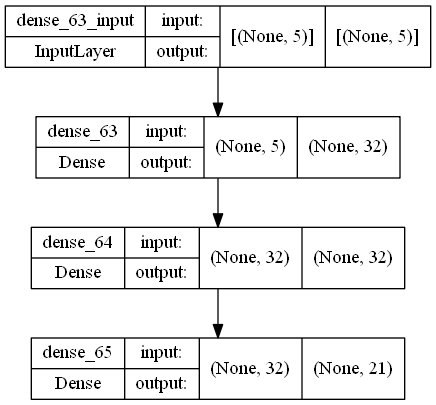

In [412]:
tf.keras.utils.plot_model(qAgent.agent.model, show_shapes=True)

In [ ]:
# Training for Q agent
NUM_EPISODES = 2000
REPLAY_INTERVAL = 10
UPDATE_INTERVAL = REPLAY_INTERVAL * 2
EPSILON_START = 1.0
EPSILON_DECAY = 0.995

qAgent.epsilon = EPSILON_START
rewards = []
histories = []

for e in range(NUM_EPISODES):
    train = True if (e // REPLAY_INTERVAL > 0 and e % REPLAY_INTERVAL == 0) else False
    sim = Simulation(datetime.date(2022, 1, 1), datetime.date(2022, 6, 1), qAgent)
    
    sim.simulate()
    rewards.append(qAgent.cum_reward)
    histories.append(sim.history)
    
    print(f"Episode {e} for episolon {qAgent.epsilon} reward {rewards[-1]} and final capital {sim.history[-1]}")
    qAgent.epsilon *= EPSILON_DECAY
    if(train):
        print("Training")
        sns.lineplot(x = range(len(rewards)), y = rewards)
        plt.savefig(f"figures/rewards.png")
        plt.clf()
        qAgent.agent.replay()
        
    
    if(train and e % UPDATE_INTERVAL == 0):
        print("Updating and Saving")
        qAgent.agent.updateModel()
    qAgent.reset_episode()

total buys : 1133
total sells: 1151
total_holds : 118
Episode 0 for episolon 1.0 reward 75504.5011288246 and final capital 6450.507336628914
total buys : 1152
total sells: 1129
total_holds : 121
Episode 1 for episolon 0.995 reward 36023.22000502865 and final capital 6858.6703566651795
total buys : 1195
total sells: 1100
total_holds : 107
Episode 2 for episolon 0.990025 reward 41588.32714155258 and final capital 7271.83756061522
total buys : 1154
total sells: 1147
total_holds : 101
Episode 3 for episolon 0.985074875 reward 45401.86447565634 and final capital 7015.389436741096
total buys : 1171
total sells: 1105
total_holds : 126
Episode 4 for episolon 0.9801495006250001 reward 42315.13046653727 and final capital 6723.268799107603
total buys : 1171
total sells: 1113
total_holds : 118
Episode 5 for episolon 0.9752487531218751 reward 56794.780046271575 and final capital 6532.853367470418
total buys : 1143
total sells: 1128
total_holds : 131
Episode 6 for episolon 0.9703725093562657 reward 

In [387]:
qAgent.reset_episode()
qAgent.epsilon = 0

In [398]:
sim_q = Simulation(datetime.date(2022,1,1), datetime.date(2022,5,1), qAgent)

In [399]:
sim_q.simulate()

total buys : 609
total sells: 1456
total_holds : 0


<AxesSubplot:title={'center':'Q learning Agent'}, xlabel='Days', ylabel='Value'>

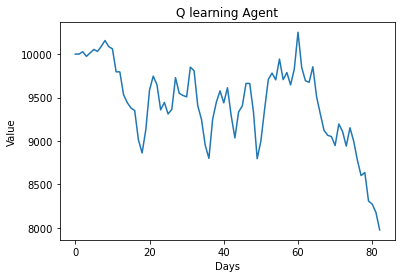

In [419]:
p = sns.lineplot(x = range(len(sim_q.history)), y = sim_q.history)
p.set_xlabel("Days", fontsize = 10)
p.set_ylabel("Value", fontsize = 10)
p.set_title("Q learning Agent")
p

In [401]:
sim_random = Simulation(datetime.date(2022,1,1), datetime.date(2022,5,1), AgentRandom(stock_tweets, random_state=time.time()))

In [402]:
sim_random.simulate()

total buys : 375
total sells: 311
total_holds : 354


<AxesSubplot:title={'center':'Random Agent'}, xlabel='Days', ylabel='Value'>

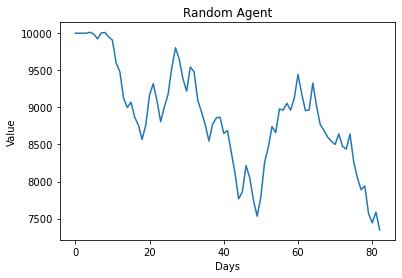

In [420]:
p = sns.lineplot(x = range(len(sim_random.history)), y = sim_random.history)
p.set_xlabel("Days", fontsize = 10)
p.set_ylabel("Value", fontsize = 10)
p.set_title("Random Agent")
p

In [404]:
sim_sentiment = Simulation(datetime.date(2022,1,1), datetime.date(2022,5,1), AgentSentiment(stock_tweets, window_size=3))

In [405]:
sim_sentiment.simulate()

total buys : 725
total sells: 594
total_holds : 746


<AxesSubplot:title={'center':'Sentiment Agent'}, xlabel='Days', ylabel='Value'>

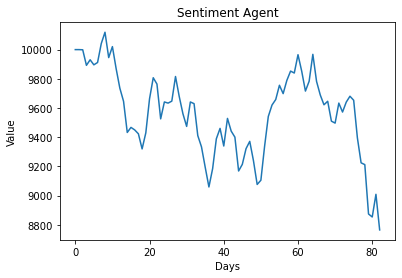

In [421]:
p = sns.lineplot(x = range(len(sim_sentiment.history)), y = sim_sentiment.history)
p.set_xlabel("Days", fontsize = 10)
p.set_ylabel("Value", fontsize = 10)
p.set_title("Sentiment Agent")
p

<AxesSubplot:title={'center':'Comparison'}, xlabel='Days', ylabel='Value'>

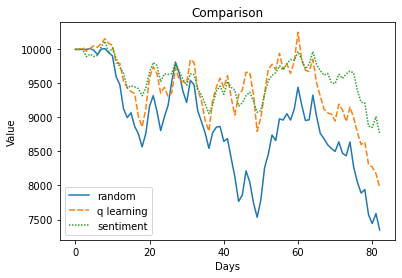

In [425]:
p = sns.lineplot(data = {'random' : sim_random.history, 'q learning' : sim_q.history, 'sentiment' : sim_sentiment.history})

p.set_xlabel("Days", fontsize = 10)
p.set_ylabel("Value", fontsize = 10)
p.set_title("Comparison")
p

<AxesSubplot:xlabel='date', ylabel='Count'>

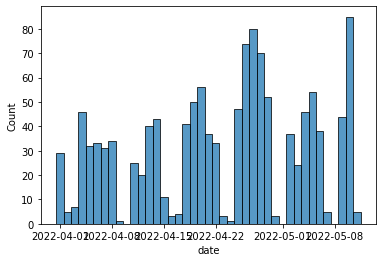

In [156]:
sns.histplot(stock_tweets[stock_tweets.date >= datetime.date(2022,4,1)].date)

In [ ]:
stock_tweets[(stock_tweets.date >= datetime.date(2022,2,1)) & (stock_tweets.date < datetime.date(2022,3,1))].shape

(215, 8)